<a href="https://colab.research.google.com/github/GarryNeKasparov/Digit-Recognizer/blob/main/Square.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
batch_size_train = 64
batch_size_test = 1000
random_seed = 1

In [3]:
Transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

In [4]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [5]:
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=True, download=True,
                             transform=Transform),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=False, download=True,
                             transform=Transform),
  batch_size=batch_size_test, shuffle=True)


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

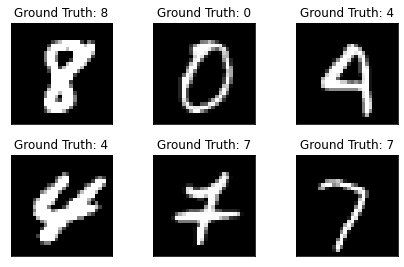

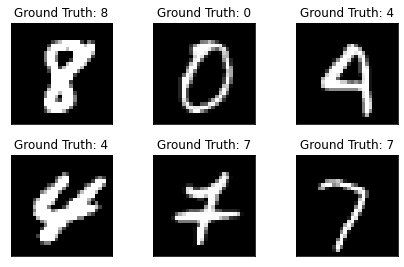

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.maxPolling = nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
    self.linear2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxPolling(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxPolling(x)
    x = x.reshape(x.size(0), -1)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.dropout(x)

    pred = self.linear2(x)

    return pred
        

In [13]:
model = Model()

In [14]:
model

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPolling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
n_epochs = 100
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in n_epochs:
  total_train_loss = 0
  total_val_loss = 0

  model.train()
  for itr, (image, label) in 